In [7]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l  #实现过的py

In [8]:
def  synthetic_data(w,b,num_examples):
    '''生成y=Xw+b+e
    '''
    X=torch.normal(0,1,(num_examples,len(w))) #二维
    y = torch.matmul(X,w) + b
    y += torch.normal(0,0.01,y.shape)
    return X,y.reshape((-1,1))

true_w = torch.tensor([2,-3.4])
true_b = 4.2
features,labels = synthetic_data(true_w,true_b,1000)

In [9]:
print("features:",features[0],'\nlabels:',labels[0])

features: tensor([-0.5149, -0.1788]) 
labels: tensor([3.7767])


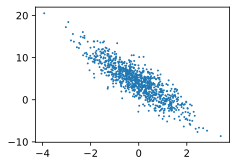

In [10]:
d2l.set_figsize()
d2l.plt.scatter(features[:,1].detach().numpy(),labels.detach().numpy(),1) # detach出计算图才能转到numpy中

In [11]:
# 每次读取小批量
def  data_iter(batch_size,features,labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)   # 假设独立，这些样本是随机读取，没有特定顺序
    for i in range(0,num_examples,batch_size):
        batch_indices = torch.tensor( indices[i:min(i+batch_size,num_examples)])        # 保证所有样本取到
        yield features[batch_indices],labels[batch_indices]  # 迭代器赋值

batch_size = 10
for X,y in data_iter(batch_size,features,labels):
    print(X,'\n',y)
    break

tensor([[ 1.1556,  0.8147],
        [-0.0992, -0.1611],
        [ 1.6437, -2.2569],
        [ 1.3630, -3.0309],
        [-0.2618,  0.1932],
        [-1.3906, -1.2652],
        [ 2.1823, -0.1878],
        [ 0.2473,  0.4949],
        [-2.3264, -1.0483],
        [-1.5202, -0.7452]]) 
 tensor([[ 3.7235],
        [ 4.5537],
        [15.1672],
        [17.2295],
        [ 3.0230],
        [ 5.7031],
        [ 9.2099],
        [ 2.9985],
        [ 3.0908],
        [ 3.7161]])


In [30]:
# 参数初始化
w = torch.normal(0,0.01,size=(2,1),requires_grad=True)
b = torch.zeros(1,requires_grad=True)

In [13]:
def linreg(X,w,b):
    '''线性回归模型'''
    return torch.matmul(X,w) +b

In [14]:
# 损失函数
def squared_loss(y_hat,y):
    '''均方误差'''
    return  (y_hat-y.reshape(y_hat.shape))**2/2  # 方便计算

In [15]:
# 优化算法
def sgd(params,lr,batch_size):
    '''min_batch sgd'''
    with torch.no_grad():  #不构建计算图进行梯度计算
        for param in params:
            param -= lr*param.grad/batch_size  #损失函数未求平均
            param.grad.zero_()

In [31]:
# 训练过程
lr = 0.3        # 需要对w和b进行随机初始化，梯度不会影响
num_epochs = 10  #先确定一个大的，根据目标函数的变化调整
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X,y in data_iter(batch_size,features,labels):
        l = loss(net(X,w,b),y) # 向量（batch_size,1）
        l.sum().backward()   # 计算梯度
        sgd([w,b],lr,batch_size) #更新梯度
    with torch.no_grad():
        train_1 = loss(net(features,w,b),labels)
        print(f'epoch{epoch+1},loss{float(train_1.mean()):f}') 
        # torch计算中，直接用mean函数即可，不用求和

epoch1,loss0.000048
epoch2,loss0.000049
epoch3,loss0.000049
epoch4,loss0.000048
epoch5,loss0.000052
epoch6,loss0.000048
epoch7,loss0.000050
epoch8,loss0.000053
epoch9,loss0.000050
epoch10,loss0.000048


In [32]:
print(f'w的估计误差:{true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差:{true_b-b}')

w的估计误差:tensor([-0.0006,  0.0002], grad_fn=<SubBackward0>)
b的估计误差:tensor([-0.0001], grad_fn=<RsubBackward1>)


In [50]:
# 直接掉包实现
import numpy as np
import torch
from torch.utils import data
from d2l import torch as d2l

true_w = torch.tensor([2,-3.4])
true_b = 4.2
features,labels = d2l.synthetic_data(true_w,true_b,1000)

In [51]:
def load_array(data_arrays,batch_size,is_train=True):
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset,batch_size,shuffle=is_train)

batch_size = 10
data_iter = load_array((features,labels),batch_size)
data_iter
next(iter(data_iter))#生成迭代器，然后next不断打印下一条，直到空值

[tensor([[-1.0498, -2.3586],
         [-0.8676,  0.5569],
         [ 1.7708,  0.9238],
         [ 1.5935, -0.2402],
         [-1.2230, -1.0150],
         [-0.1108,  0.4947],
         [ 0.9535, -0.0474],
         [ 0.2432,  1.0056],
         [-0.9812,  0.2984],
         [-1.2035,  0.4104]]),
 tensor([[10.1286],
         [ 0.5637],
         [ 4.5902],
         [ 8.2032],
         [ 5.2233],
         [ 2.2972],
         [ 6.2820],
         [ 1.2659],
         [ 1.2090],
         [ 0.3946]])]

In [52]:
# 模型
from torch import nn

net = nn.Sequential(nn.Linear(2,1)) # 将层按顺序放一个容器中
net[0].weight.data.normal_(0,0.01) # _ 替换 w
net[0].bias.data.fill_(0) # b

tensor([0.])

In [53]:
# 误差
loss = nn.MSELoss()
# 优化
trainer = torch.optim.SGD(net.parameters(),lr=0.03)

In [54]:
# 训练
num_epochs = 3
for epoch in range(num_epochs):
    for X,y in data_iter:
        l = loss(net(X),y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
    l = loss(net(features),labels)
    print(f'epoch{epoch+1},loss  {l:f}')

epoch1,loss  0.000217
epoch2,loss  0.000099
epoch3,loss  0.000099


 - 损失函数
- 不一定能收敛到最优点
- 算法选择并不那么重要，结果不一定好